In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sklearn.decomposition as PCA
import sklearn.preprocessing as StandardScaler
from sklearn.impute import KNNImputer
import scipy.stats as stats

# Travail à faire
Vous êtes missionné sur le projet de nettoyage et exploration des données en interne, afin de déterminer la faisabilité de cette idée d’application de Santé publique France.

# 1. Présentation générale du jeu de données

In [2]:
produit = pd.read_csv('prod.csv', sep='\t', low_memory=False)
produit.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- La dimension du dataframe

In [3]:
produit.shape

(320772, 162)

- La méthode `info` nous donne des indications globales

In [4]:
produit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


### Aperçu des valeurs manquantes

- Le nombre de valeur manquante par colonne

In [5]:
produit.isna().sum()

code                           23
url                            23
creator                         2
created_t                       3
created_datetime                9
                            ...  
carbon-footprint_100g      320504
nutrition-score-fr_100g     99562
nutrition-score-uk_100g     99562
glycemic-index_100g        320772
water-hardness_100g        320772
Length: 162, dtype: int64

### Sélection des features sur lesquels nous allons travailler, la plupart de ces variables ont moins de moins 50% de valeurs manquantes.

In [6]:
echan = ['product_name','fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','fat_100g','carbohydrates_100g','sugars_100g','sodium_100g','nutrition_grade_fr','pnns_groups_1']
echan0 = produit[echan]

### Aperçu du nombre des valeurs manquantes

In [7]:
echan0.isna().sum()

product_name           17762
fiber_100g            119886
proteins_100g          60850
vitamin-a_100g        183218
vitamin-c_100g        179905
fat_100g               76881
carbohydrates_100g     77184
sugars_100g            75801
sodium_100g            65309
nutrition_grade_fr     99562
pnns_groups_1         229259
dtype: int64

### Le pourcentage de valeurs manquantes dans chaque colonne.

In [8]:
miss = echan0.isna().mean()*100
miss

product_name           5.537266
fiber_100g            37.374210
proteins_100g         18.969860
vitamin-a_100g        57.117828
vitamin-c_100g        56.085007
fat_100g              23.967491
carbohydrates_100g    24.061951
sugars_100g           23.630803
sodium_100g           20.359944
nutrition_grade_fr    31.038245
pnns_groups_1         71.471014
dtype: float64

<AxesSubplot:>

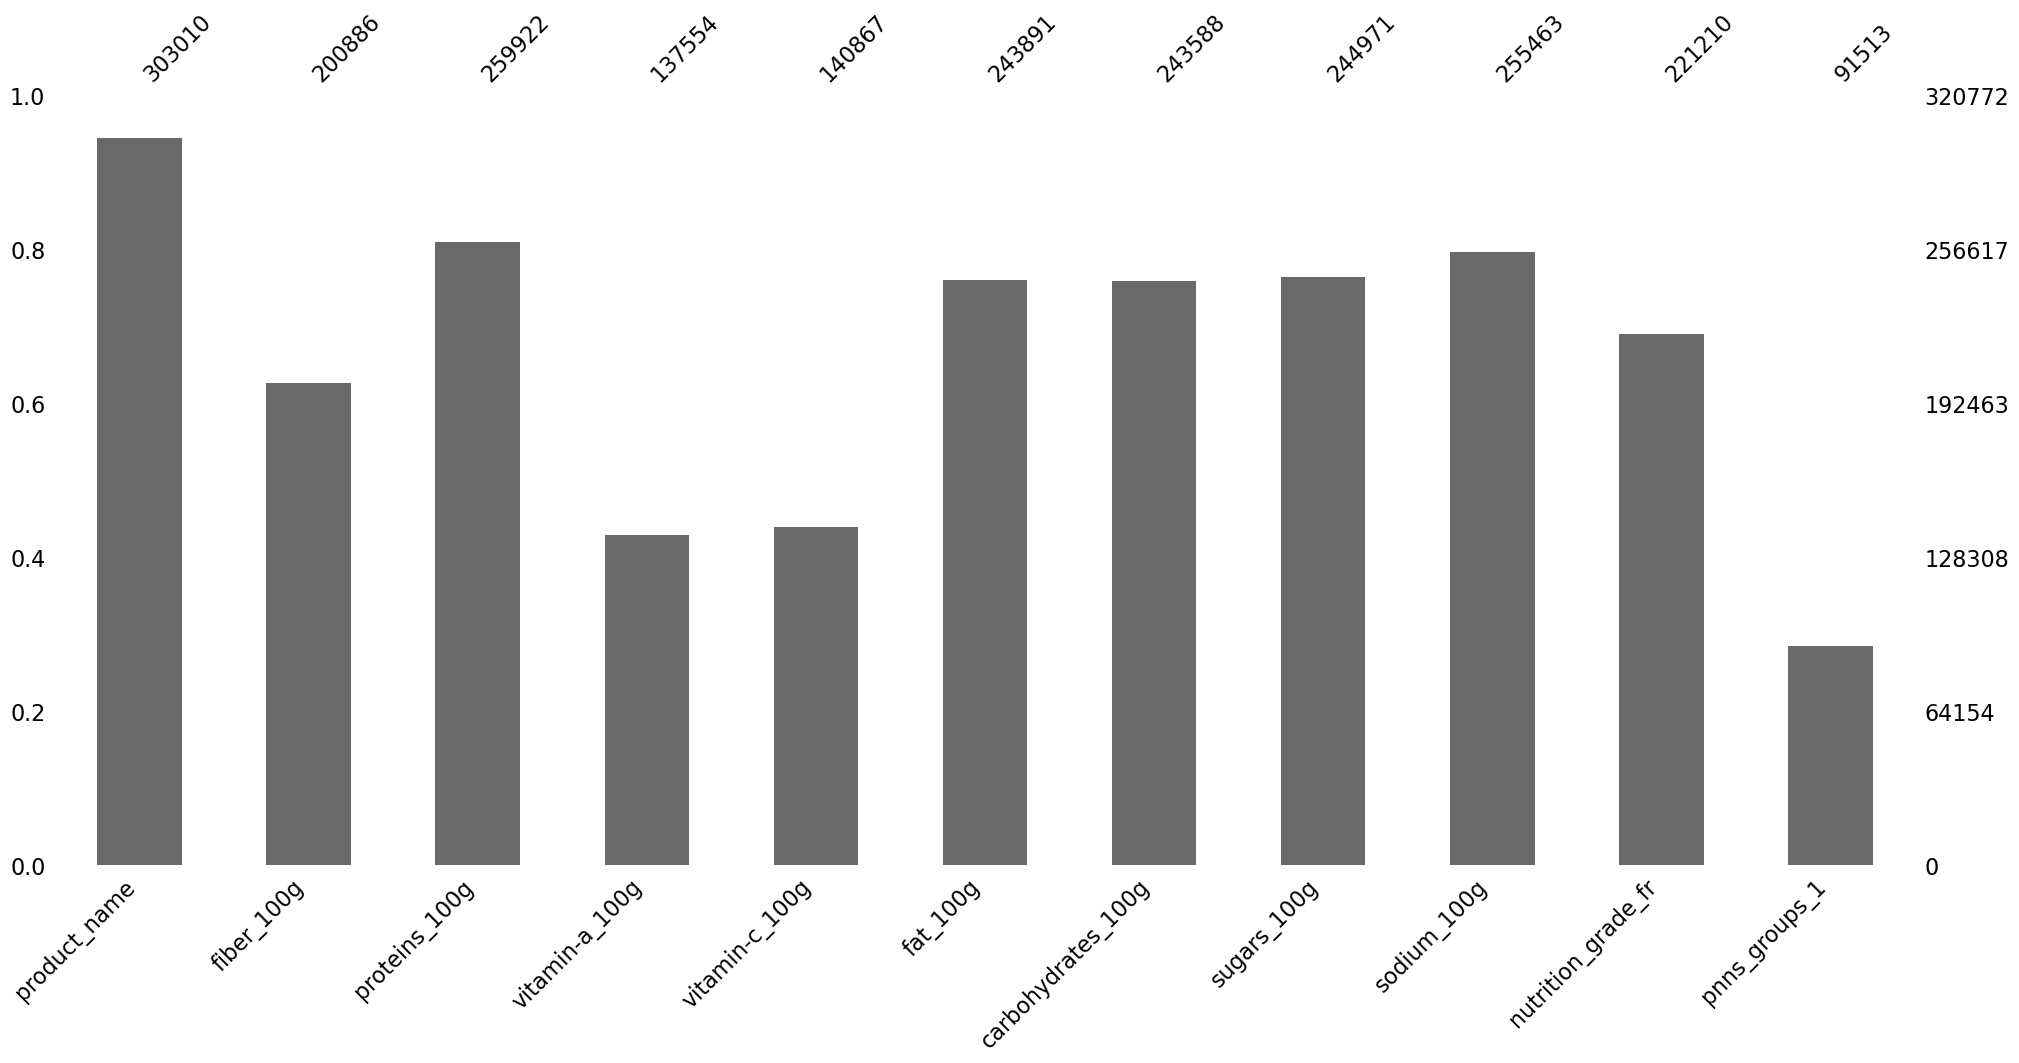

In [9]:
msno.bar(echan0)

# 2. Nettoyage des données

In [10]:
echan0.shape

(320772, 11)

### 2.1 Traitement des valeurs manquantes

#### - Suppression des lignes dont le nom produit n'est pas renseigné et autres nom de produit non conforme

In [11]:
echan0 = echan0.dropna(subset=['product_name'])

In [12]:
echan0 = echan0.dropna(subset=['pnns_groups_1'])

In [13]:
echan0 = echan0.dropna(subset=['nutrition_grade_fr'])

In [14]:
echan0.drop(echan0[echan0['product_name'] == ' '].index, inplace = True)

#### - Filtrage sur les differents 'Features' fibre, proteins_100g, vitamin-c_100g, sodium_100g, carbohydrates_100g, etc. 

In [15]:
echan0 = echan0.drop(echan0[(echan0['fiber_100g'] < 0) & (echan0['fiber_100g'] < 100 )].index)

In [16]:
echan0 = echan0.drop(echan0[(echan0['proteins_100g'] < 0) & (echan0['proteins_100g'] < 100 )].index)

In [17]:
echan0 = echan0.drop(echan0[(echan0['vitamin-a_100g'] < 0) & (echan0['vitamin-a_100g'] < 100 )].index)

In [18]:
echan0 = echan0.drop(echan0[(echan0['vitamin-c_100g'] < 0) & (echan0['vitamin-c_100g'] < 100 )].index)

In [19]:
echan0 = echan0.drop(echan0[(echan0['sodium_100g'] < 0) & (echan0['sodium_100g'] < 100 )].index)

In [20]:
echan0 = echan0.drop(echan0[(echan0['carbohydrates_100g'] < 0) & (echan0['carbohydrates_100g'] < 100)].index)

In [21]:
echan0 = echan0.drop(echan0[(echan0['fat_100g'] < 0) & (echan0['fat_100g'] < 100)].index)

In [22]:
echan0 = echan0.drop(echan0[(echan0['sugars_100g'] < 0) & (echan0['sugars_100g'] < 100)].index)

#### - Remplissage des valeurs manquantes par median mean ou 0 en fonction des features 

In [23]:
#imputer = KNNImputer(n_neighbors=4)
#echan0['fat_100g'] = imputer.fit_transform(echan0['fat_100g'])

In [24]:
echan0.loc[echan0['fiber_100g'].isna(), 'fiber_100g'] = 0

In [25]:
echan0.loc[echan0['proteins_100g'].isna(), 'proteins_100g'] = echan0['proteins_100g'].mean()

In [26]:
echan0.loc[echan0['fat_100g'].isna(), 'fat_100g'] = echan0['fat_100g'].mean()  

In [27]:
echan0.loc[echan0['carbohydrates_100g'].isna(), 'carbohydrates_100g'] = echan0['carbohydrates_100g'].median() 

In [28]:
echan0.loc[echan0['sugars_100g'].isna(), 'sugars_100g'] = echan0['sugars_100g'].mean()  

In [29]:
echan0.loc[echan0['sodium_100g'].isna(), 'sodium_100g'] = echan0['sodium_100g'].median()  

In [30]:
echan0.loc[echan0['vitamin-c_100g'].isna(), 'vitamin-c_100g'] = echan0['vitamin-c_100g'].median()
echan0['vitamin-c_100g'] =echan0['vitamin-c_100g']*10

In [31]:
echan0.loc[echan0['vitamin-a_100g'].isna(), 'vitamin-a_100g'] = echan0['vitamin-a_100g'].median()
echan0['vitamin-a_100g'] = echan0['vitamin-a_100g']*10

In [32]:
echan0 = echan0.drop(echan0[(echan0['vitamin-a_100g'] < 0) & (echan0['vitamin-a_100g'] < 100 )].index)

In [33]:
echan0

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
106,Lion Peanut x2,2.500,2.500,0.000529,0.10000,20.000000,70.00,57.500,0.038000,e,unknown
174,Salade Cesar,2.000,22.000,0.000000,0.00000,12.000000,23.00,0.000,0.850000,c,Fruits and vegetables
180,Chaussons tressés aux pommes,2.000,3.330,0.000000,0.01600,10.700000,38.70,24.700,0.255000,c,Sugary snacks
181,Pain Burger Artisan,2.220,10.000,0.000000,0.00000,1.110000,53.30,1.110,0.600000,b,unknown
185,Quiche Lorraine,0.357,5.360,0.000107,0.00429,6.790000,7.86,0.714,0.196000,b,Composite foods
...,...,...,...,...,...,...,...,...,...,...,...
320693,Santa Cruz Chilli & Lime Dressing,0.600,0.300,0.000529,0.10000,6.900000,23.10,16.700,0.213000,c,Fat and sauces
320702,Fisherman's Friend Miel-Citron,1.470,0.004,0.000529,0.10000,1.300000,95.31,0.100,0.000394,b,Sugary snacks
320734,Nature cheddar and red onion crisps,5.600,7.800,0.000529,0.10000,13.499853,15.00,1.800,0.531496,c,Salty snacks
320751,Tartines craquantes bio au sarrasin,5.900,13.000,0.000529,0.10000,2.800000,74.80,2.600,0.267717,a,Cereals and potatoes


#### - Le pourcentage de données manquantes

In [34]:
miss = echan0.isna().mean()*100
miss

product_name          0.0
fiber_100g            0.0
proteins_100g         0.0
vitamin-a_100g        0.0
vitamin-c_100g        0.0
fat_100g              0.0
carbohydrates_100g    0.0
sugars_100g           0.0
sodium_100g           0.0
nutrition_grade_fr    0.0
pnns_groups_1         0.0
dtype: float64

### 2.2  Recherche et suppression des duplicatas

In [35]:
dupli = echan0[echan0.duplicated(keep=False)]
dupli

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
564,Pur Soup' Velouté de légumes,0.8,0.800000,0.001200,0.1,2.100000,5.3,2.400000,0.295276,b,Fruits and vegetables
595,Yellow Mustard,0.0,7.486546,0.000529,0.1,13.499853,15.0,13.094281,0.200000,b,Fat and sauces
628,British plain flour,3.1,9.400000,0.000529,0.1,1.300000,77.7,1.500000,0.003940,a,Cereals and potatoes
884,British plain flour,3.1,9.400000,0.000529,0.1,1.300000,77.7,1.500000,0.003940,a,Cereals and potatoes
1345,Nutella,2.7,5.410000,0.000000,0.0,32.400000,56.8,56.800000,0.040500,e,unknown
...,...,...,...,...,...,...,...,...,...,...,...
318503,Kinder Schoko-Bons,0.0,8.300000,0.000529,0.1,36.600000,52.5,52.200000,0.110236,e,Sugary snacks
319170,Vegemite,7.8,25.400000,0.000529,0.1,1.000000,19.9,2.200000,3.450000,c,unknown
319927,Speisequark Magerstufe,0.0,12.000000,0.000529,0.1,0.200000,4.1,4.100000,0.039370,a,Milk and dairy products
320299,Vegemite,7.8,25.400000,0.000529,0.1,1.000000,19.9,2.200000,3.450000,c,unknown


In [36]:
echan0 = echan0.drop_duplicates(keep='first')

#### Verification après nettoyage

In [37]:
echan0.duplicated().sum()

0

## Echantillonnage avec la fonction *sample()*

In [38]:
jeu0 = echan0.sample(frac=0.9)
jeu0

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
229827,Riz de Camargue Long Complet,3.5,7.50,0.000529,0.1,3.600000,75.30,1.10,0.003937,a,Cereals and potatoes
242496,Boisson Lactée Goût Chocolat,0.1,2.50,0.000529,0.1,1.000000,11.00,10.00,0.049213,e,Beverages
191943,Ma pâte à Tortillas de Maïs,3.8,7.90,0.000529,0.1,1.200000,71.60,4.20,0.590551,b,unknown
232964,Riz au lait tradition,0.0,3.94,0.000529,0.1,4.400000,16.96,8.04,0.102362,c,Milk and dairy products
194682,Bubblizz Bomb,0.0,0.00,0.000529,0.1,0.300000,88.60,58.00,0.275591,d,Sugary snacks
...,...,...,...,...,...,...,...,...,...,...,...
292187,Perrier 1l aromatisé fraise,0.0,0.00,0.000529,0.1,13.499853,15.00,0.00,0.000000,b,Beverages
242158,Colin d'Alaska,1.0,11.50,0.000529,0.1,9.400000,15.00,1.20,0.810000,c,Fish Meat Eggs
227890,Jambon au torchon,0.0,20.00,0.000529,0.1,11.000000,0.50,0.50,0.629921,d,Fish Meat Eggs
221933,Savoie Yaourt aux marrons,0.0,3.60,0.000529,0.1,3.900000,15.70,13.90,0.039370,c,unknown


In [39]:
jeu0_C=jeu0

In [40]:
jeu0.duplicated().sum()

0

# 3. Analyses descriptives

### 3.1 Analyses univariées

### 3.1.1 Variables quantitatives

In [41]:
jeu0.describe()

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
count,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000,53690.000000
mean,1.811662,7.507015,0.000756,0.111019,13.340001,27.334836,13.098145,0.412962
std,3.665611,7.483037,0.034885,0.967953,16.224371,26.609084,18.561902,1.696970
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.800000,0.000529,0.100000,1.500000,4.800000,1.000000,0.030000
50%,0.200000,5.900000,0.000529,0.100000,8.000000,15.000000,4.100000,0.200000
75%,2.445000,10.200000,0.000529,0.100000,20.000000,52.000000,16.800000,0.472441
max,178.000000,100.000000,8.000000,180.000000,380.000000,190.000000,134.000000,117.165354


In [42]:
ess = jeu0.groupby('nutrition_grade_fr')['proteins_100g'].mean().reset_index()
ess

,nutrition_grade_fr,proteins_100g
0,a,7.498870
1,b,6.054280
2,c,6.797382
3,d,9.188343
4,e,7.017820


In [43]:
es = jeu0.groupby('nutrition_grade_fr')['sugars_100g'].mean().reset_index()
es

,nutrition_grade_fr,sugars_100g
0,a,3.980446
1,b,4.990671
2,c,9.817941
3,d,16.827515
4,e,26.488941


In [44]:
gra = jeu0.groupby('nutrition_grade_fr')['fat_100g'].mean().reset_index()
gra

,nutrition_grade_fr,fat_100g
0,a,3.261552
1,b,4.849763
2,c,9.448364
3,d,19.278255
4,e,25.441575


#### - Le pourcentage de proteine en moyenne contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

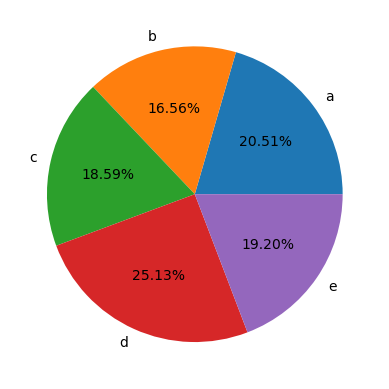

In [45]:
plt.pie(x=ess['proteins_100g'], labels=ess['nutrition_grade_fr'],  radius=1, autopct='%.2f%%')
plt.show()

#### - La moyenne en pourcentage de sucre contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

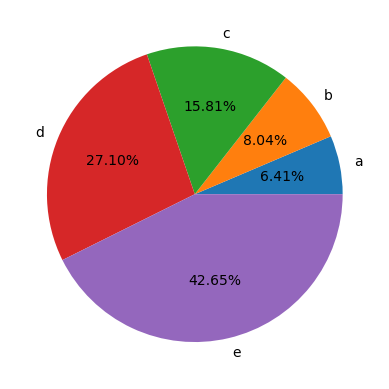

In [46]:
plt.pie(x=es['sugars_100g'], labels=es['nutrition_grade_fr'],  radius=1, autopct='%.2f%%')
plt.show()

#### - Le pourcentage de graisse en moyenne contenu dans les produits selon leur classification nutrigrade (a,b,c,d,e) 

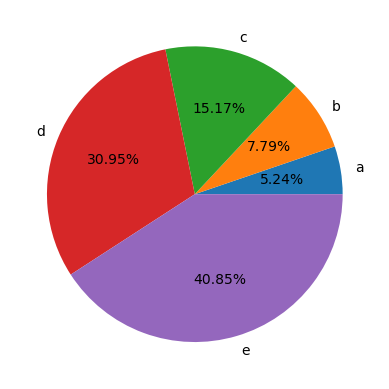

In [47]:
plt.pie(x=gra['fat_100g'], labels=gra['nutrition_grade_fr'],  radius=1, autopct='%.2f%%')
plt.show()

- Le volume de sucre en moyenne contenu dans les produits classés par catégorie nutrigrade

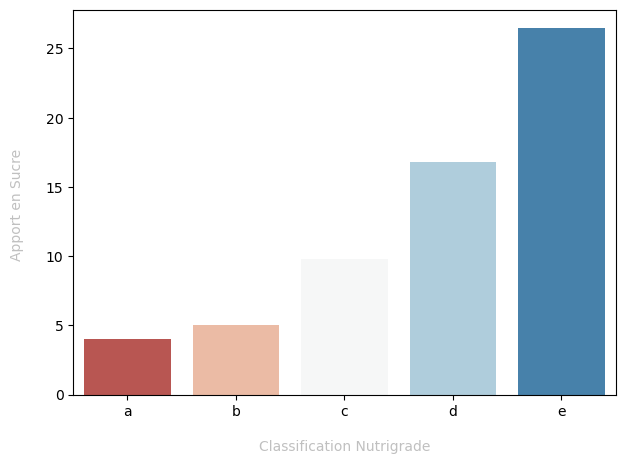

In [48]:
plt.figure(figsize=(7,5))
sns.barplot(x=es['nutrition_grade_fr'], y=es['sugars_100g'], palette="RdBu")
plt.xlabel('\nClassification Nutrigrade', fontsize=10, color='silver')
plt.ylabel("Apport en Sucre \n", fontsize=10, color='silver')
plt.show()

- La quantité de graisse en moyenne contenu dans les produits classés par catégorie nutrigrade

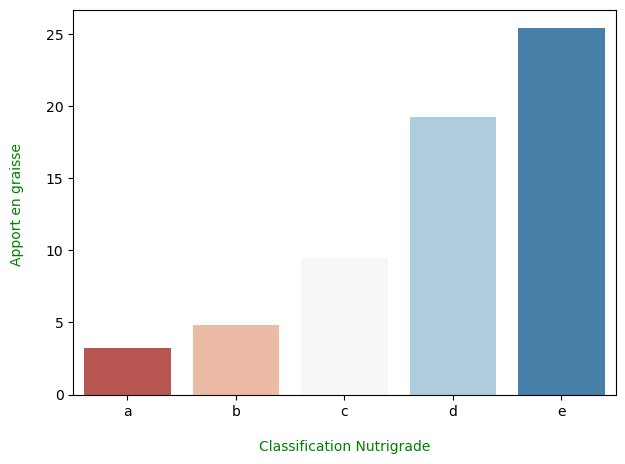

In [49]:
plt.figure(figsize=(7,5))
sns.barplot(x=gra['nutrition_grade_fr'], y=gra['fat_100g'], palette="RdBu")
plt.xlabel('\nClassification Nutrigrade', fontsize=10, color='green')
plt.ylabel("Apport en graisse \n", fontsize=10, color='green')
plt.show()

- La quantité de proteine en moyenne contenu dans les produits classés par catégorie nutrigrade

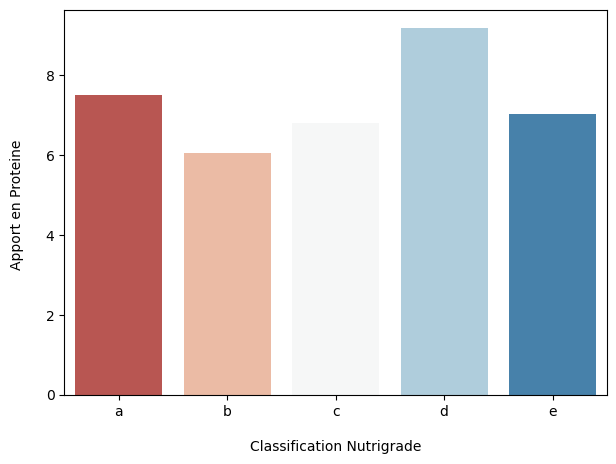

In [50]:
plt.figure(figsize=(7,5))
sns.barplot(x=ess['nutrition_grade_fr'], y=ess['proteins_100g'], palette="RdBu")
plt.xlabel('\nClassification Nutrigrade', fontsize=10, color='black')
plt.ylabel("Apport en Proteine \n", fontsize=10, color='black')
plt.show()

- La distribution par modalité de la variable *pnns_groups_1*

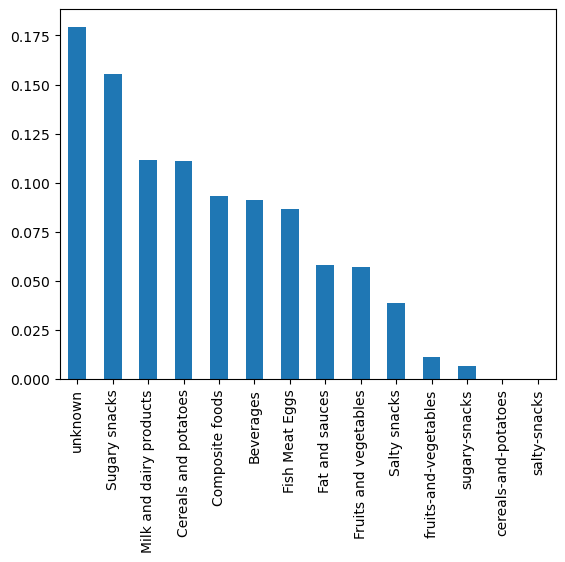

In [51]:
jeu0["pnns_groups_1"].value_counts(normalize=True).plot(kind='bar')
plt.show()

### 3.1.2 Variables qualitatives 

#### La repartition des produits par rapport à la variable categorielle *nutrigrade*

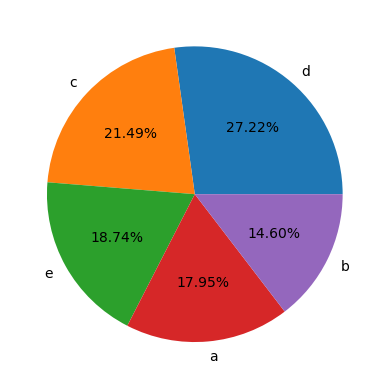

In [52]:
rep = (jeu0['nutrition_grade_fr'].value_counts())/len(jeu0)
rep
plt.pie(rep,labels=rep.index,autopct='%.2f%%')
plt.show()

#### La distribution entre deux variables qualitatives categorielles

In [53]:
jeu0.describe(include="object")

,product_name,nutrition_grade_fr,pnns_groups_1
count,53690,53690,53690
unique,46236,5,14
top,Orange,d,unknown
freq,32,14616,9630


#### Le nombre de produit par type de produits.

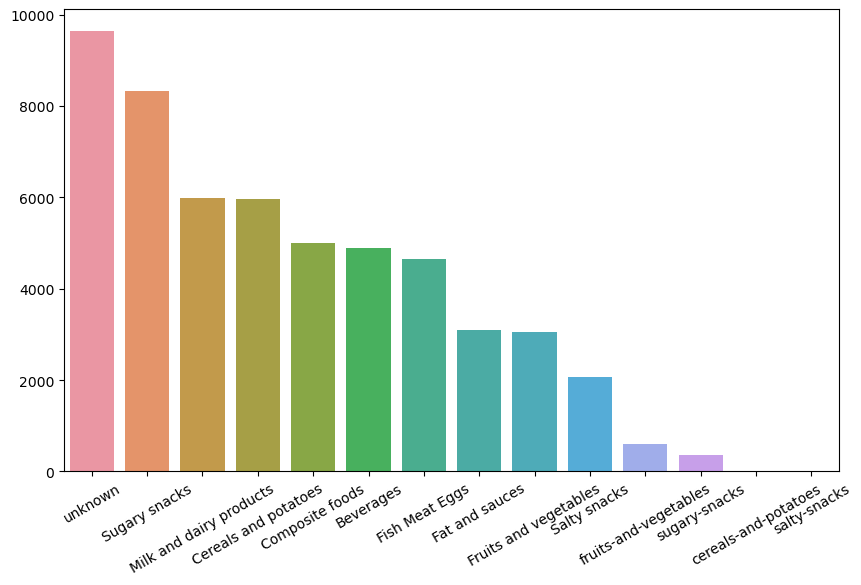

In [54]:
NbrTypeProd = jeu0['pnns_groups_1'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=NbrTypeProd.index, y=NbrTypeProd.values)
plt.xticks(rotation= 30);


### 3.2 Analyses bivarées

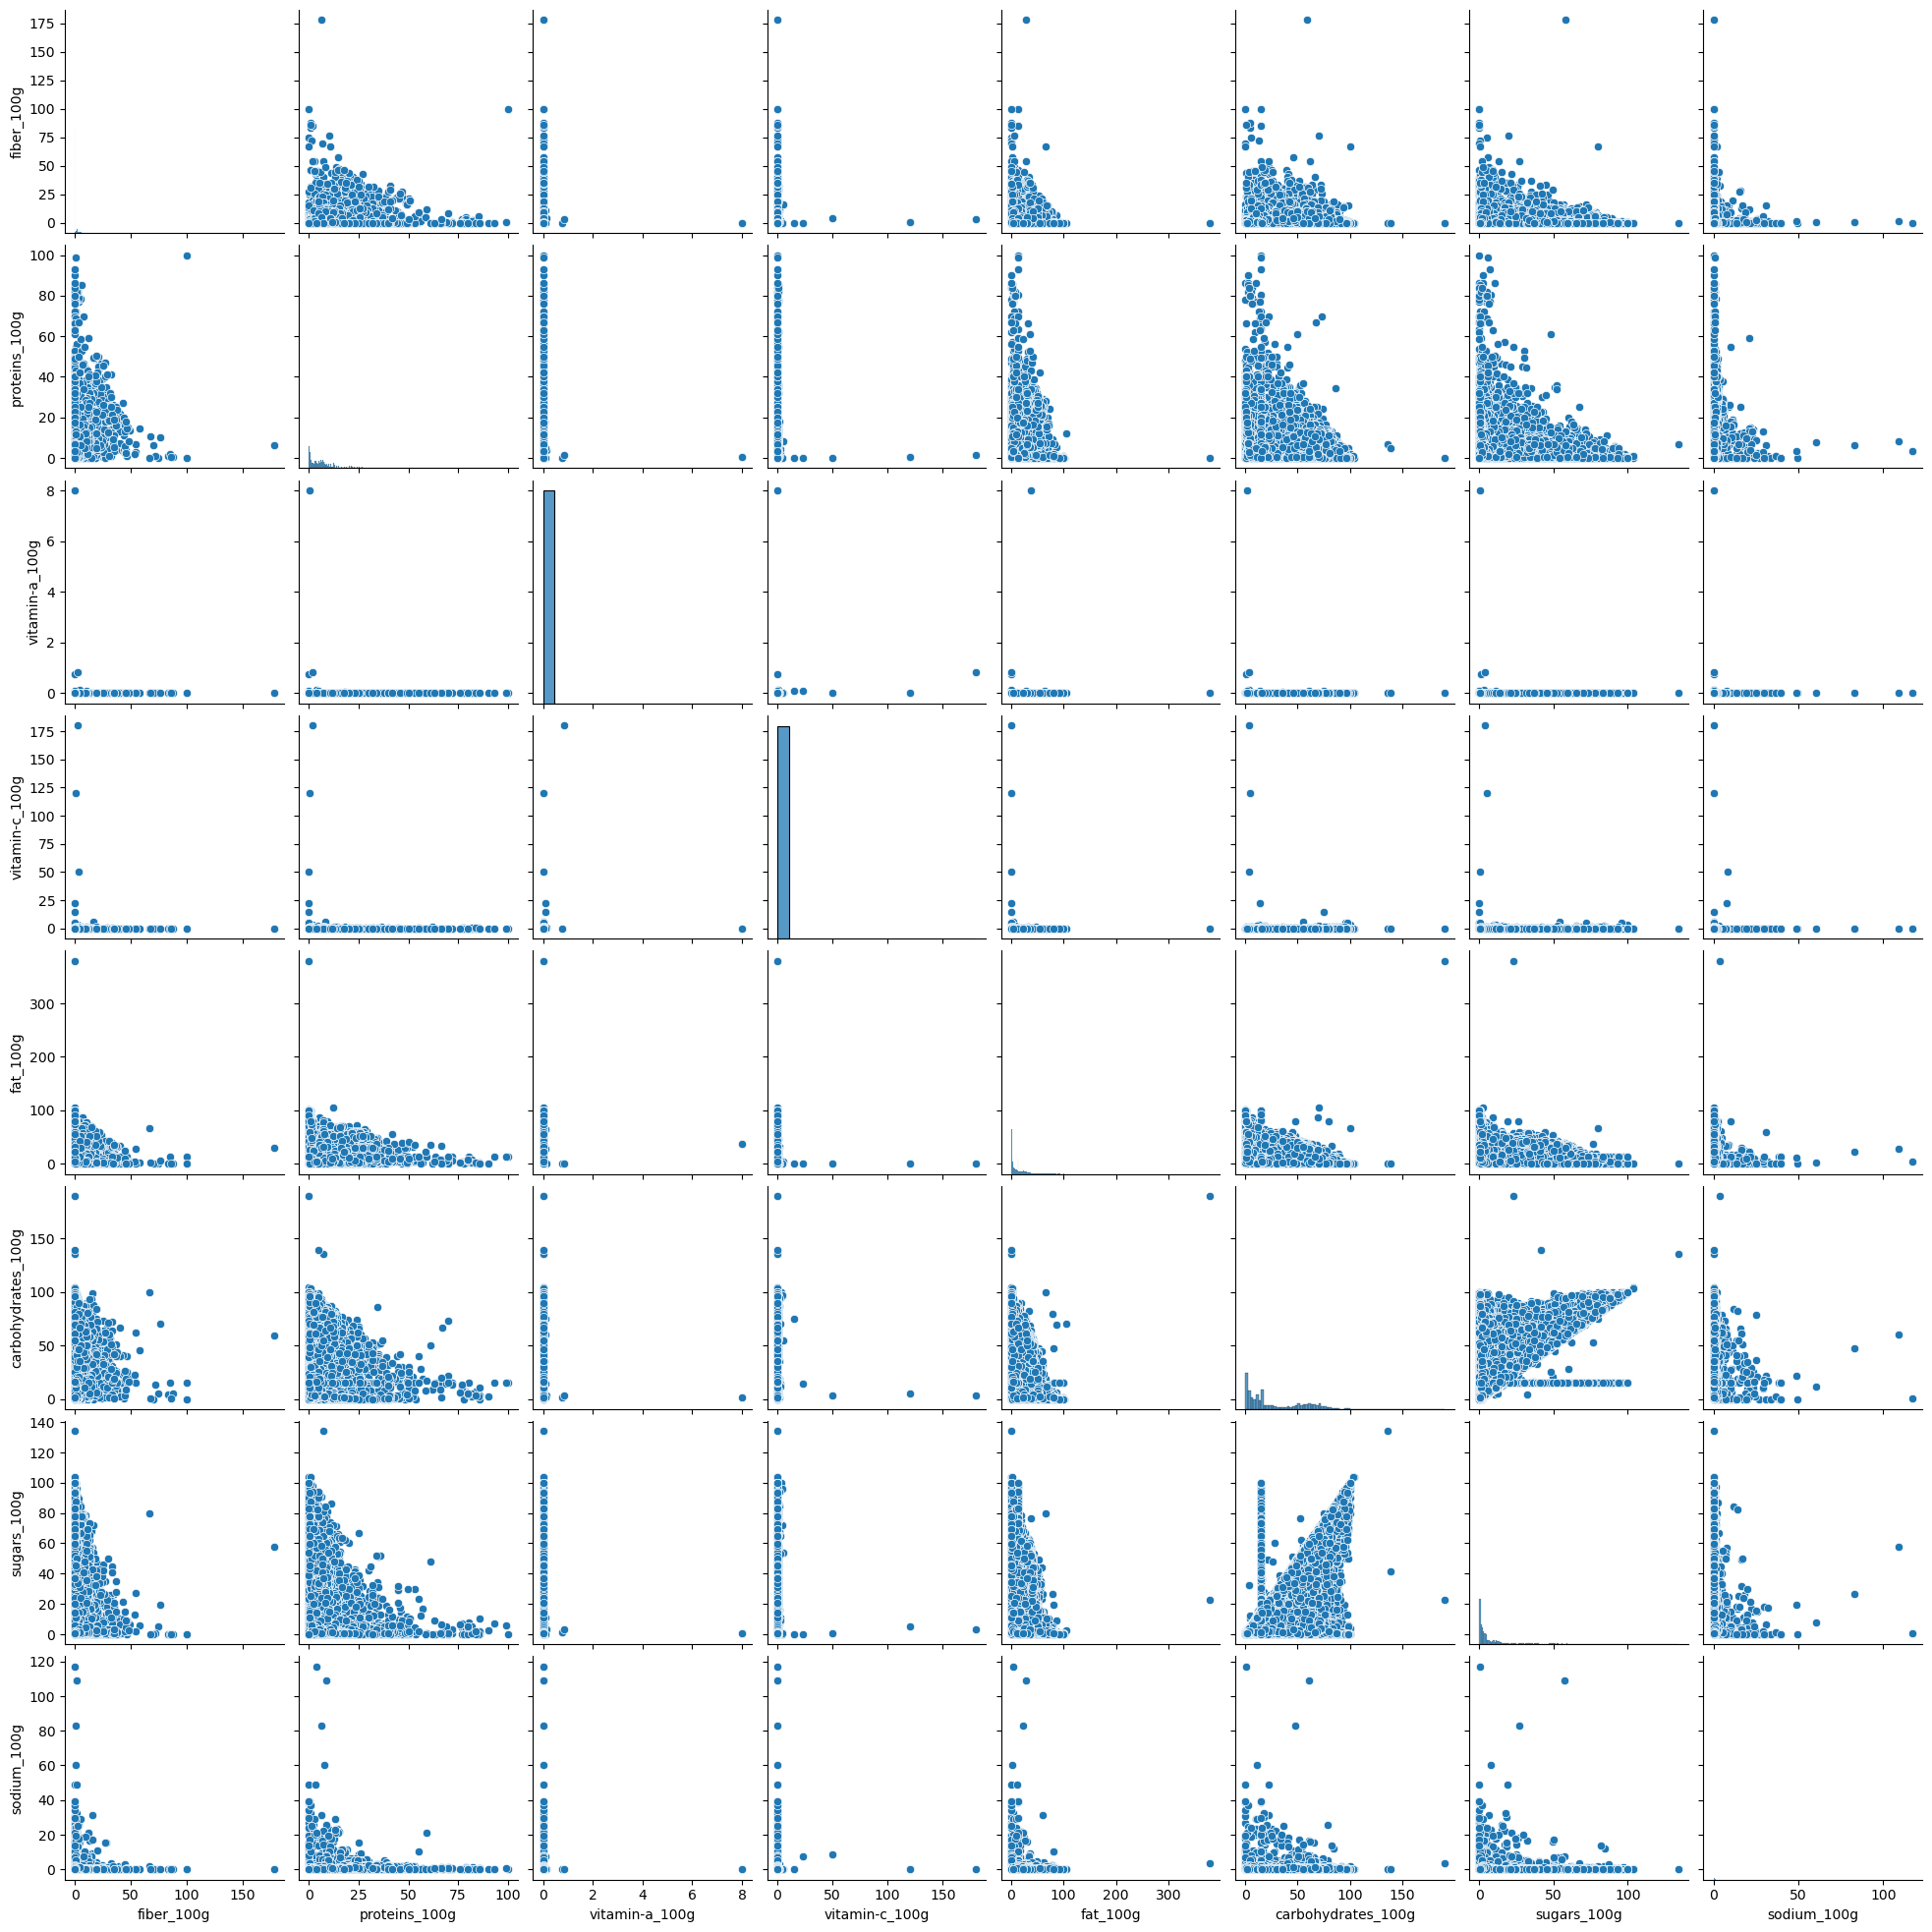

In [56]:
sns.pairplot(jeu0)

<AxesSubplot:>

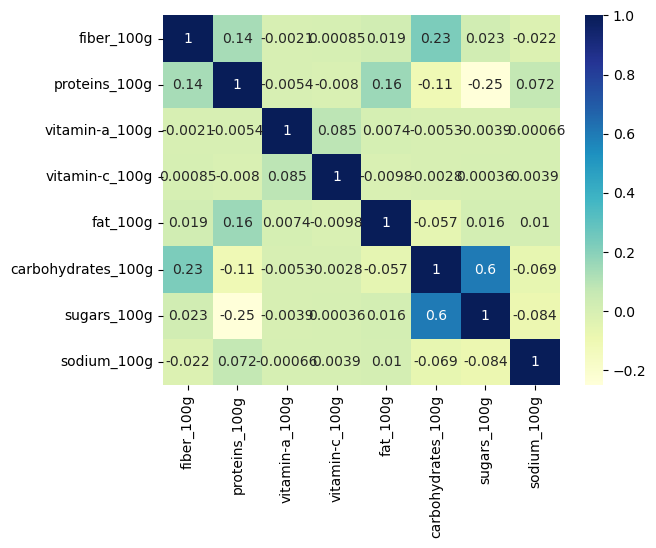

In [57]:
corr_matrix = jeu0.corr()
sns.heatmap(corr_matrix,annot=True,cmap="YlGnBu")

In [60]:
jeuD = jeu0.drop(columns =['fiber_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'sodium_100g','pnns_groups_1'])

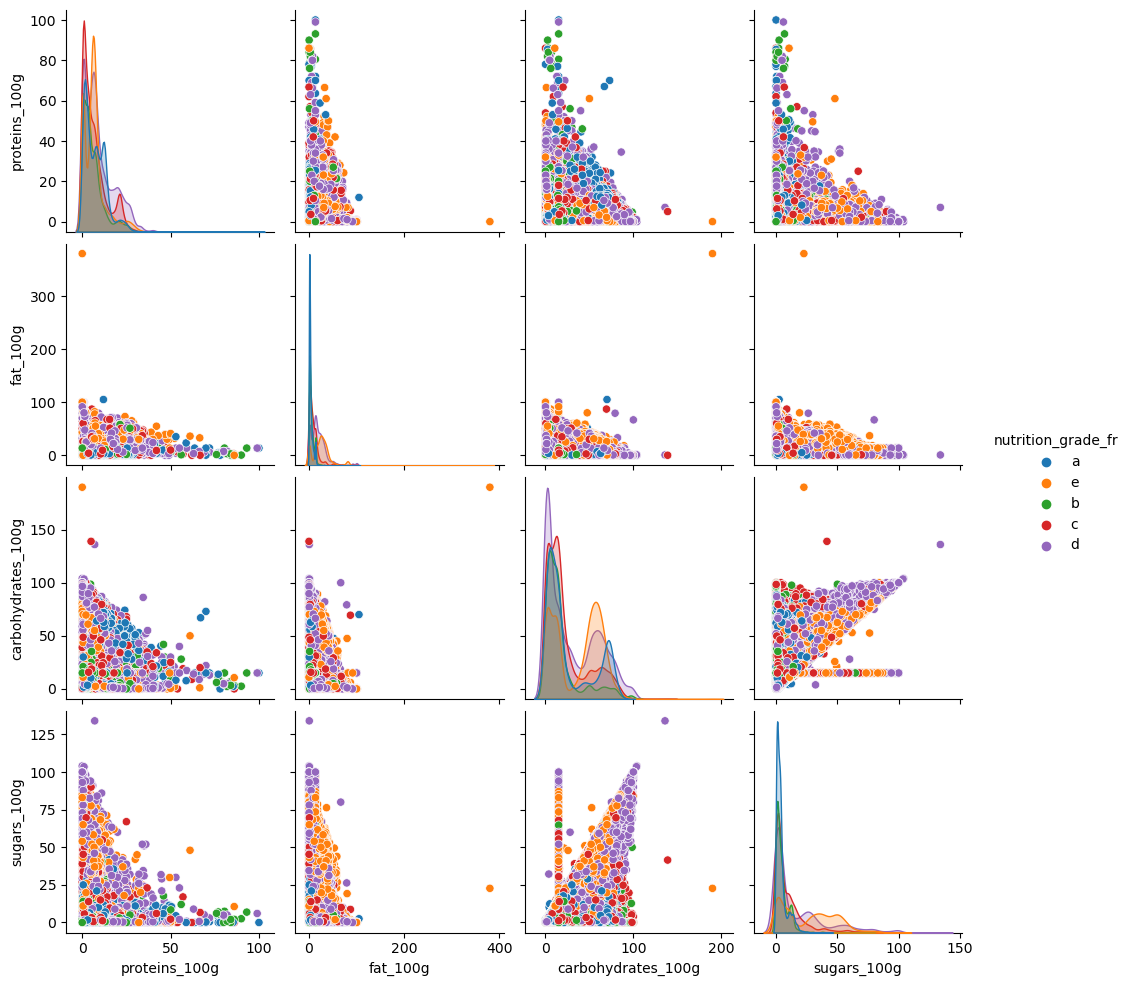

In [61]:
p=sns.pairplot(jeuD, hue ="nutrition_grade_fr")

#### Analyse Anova

In [62]:
X = "nutrition_grade_fr" 
Y = "carbohydrates_100g"
sous_echantillon = jeu0[jeu0["carbohydrates_100g"] < 100].copy()


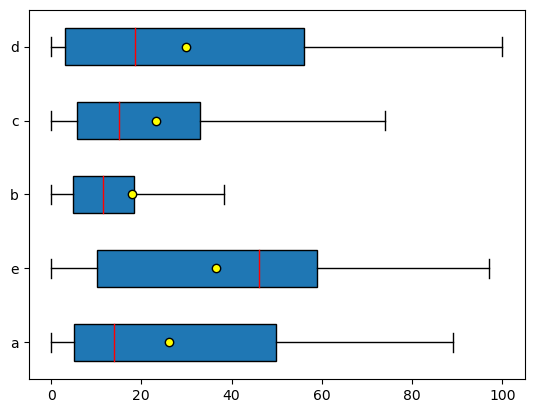

In [63]:
modalites = sous_echantillon[X].unique()
groupes = []
for i in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==i][Y])

# Propriétés graphiques   
medianprops = {'color':"red"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'yellow'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [64]:
X = "nutrition_grade_fr" 
Y = "carbohydrates_100g"
sous_echantillon = jeu0[jeu0["carbohydrates_100g"] < 100].copy()
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.04953242308723382

eta_squared = 0.04953242308723382 est plus proche de 0 que de 1 donc il n'y a pas de correletion entre le nutrigrade et le carbohydrates. 

In [65]:
Y = "fiber_100g"
X = "nutrition_grade_fr"
sous_echantillon = jeu0[jeu0["fiber_100g"] < 100].copy()

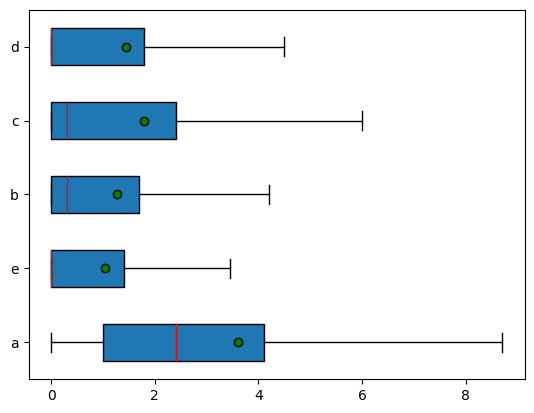

In [66]:
modalites = sous_echantillon[X].unique()
groupes = []
for j in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==j][Y])  
medianprops = {'color':"red"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'green'}    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [67]:
Y = "fiber_100g"
X = "nutrition_grade_fr"
sous_echantillon = jeu0[jeu0["fiber_100g"] < 100].copy()
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.06142906557950317

eta_squared = 0.06142906557950317 qui est beaucoup plus proche de 0 que de 1 donc il n'y a pas de correletion entre le nutrigrade et le carbohydrates.

### 3.3 Analyse multivariée (ACP)

#### Preparation des données

In [68]:
jeu0

,product_name,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
229827,Riz de Camargue Long Complet,3.5,7.50,0.000529,0.1,3.600000,75.30,1.10,0.003937,a,Cereals and potatoes
242496,Boisson Lactée Goût Chocolat,0.1,2.50,0.000529,0.1,1.000000,11.00,10.00,0.049213,e,Beverages
191943,Ma pâte à Tortillas de Maïs,3.8,7.90,0.000529,0.1,1.200000,71.60,4.20,0.590551,b,unknown
232964,Riz au lait tradition,0.0,3.94,0.000529,0.1,4.400000,16.96,8.04,0.102362,c,Milk and dairy products
194682,Bubblizz Bomb,0.0,0.00,0.000529,0.1,0.300000,88.60,58.00,0.275591,d,Sugary snacks
...,...,...,...,...,...,...,...,...,...,...,...
292187,Perrier 1l aromatisé fraise,0.0,0.00,0.000529,0.1,13.499853,15.00,0.00,0.000000,b,Beverages
242158,Colin d'Alaska,1.0,11.50,0.000529,0.1,9.400000,15.00,1.20,0.810000,c,Fish Meat Eggs
227890,Jambon au torchon,0.0,20.00,0.000529,0.1,11.000000,0.50,0.50,0.629921,d,Fish Meat Eggs
221933,Savoie Yaourt aux marrons,0.0,3.60,0.000529,0.1,3.900000,15.70,13.90,0.039370,c,unknown


In [69]:
jeu0 = jeu0.set_index('product_name', drop=True)
jeu0

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,nutrition_grade_fr,pnns_groups_1
product_name,,,,,,,,,,
Riz de Camargue Long Complet,3.5,7.50,0.000529,0.1,3.600000,75.30,1.10,0.003937,a,Cereals and potatoes
Boisson Lactée Goût Chocolat,0.1,2.50,0.000529,0.1,1.000000,11.00,10.00,0.049213,e,Beverages
Ma pâte à Tortillas de Maïs,3.8,7.90,0.000529,0.1,1.200000,71.60,4.20,0.590551,b,unknown
Riz au lait tradition,0.0,3.94,0.000529,0.1,4.400000,16.96,8.04,0.102362,c,Milk and dairy products
Bubblizz Bomb,0.0,0.00,0.000529,0.1,0.300000,88.60,58.00,0.275591,d,Sugary snacks
...,...,...,...,...,...,...,...,...,...,...
Perrier 1l aromatisé fraise,0.0,0.00,0.000529,0.1,13.499853,15.00,0.00,0.000000,b,Beverages
Colin d'Alaska,1.0,11.50,0.000529,0.1,9.400000,15.00,1.20,0.810000,c,Fish Meat Eggs
Jambon au torchon,0.0,20.00,0.000529,0.1,11.000000,0.50,0.50,0.629921,d,Fish Meat Eggs


In [70]:
jeu0_C=jeu0


In [71]:
sell = ['fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','fat_100g','carbohydrates_100g','sugars_100g','sodium_100g']
jeu0 = jeu0[sell]

In [72]:
jeu0

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
product_name,,,,,,,,
Riz de Camargue Long Complet,3.5,7.50,0.000529,0.1,3.600000,75.30,1.10,0.003937
Boisson Lactée Goût Chocolat,0.1,2.50,0.000529,0.1,1.000000,11.00,10.00,0.049213
Ma pâte à Tortillas de Maïs,3.8,7.90,0.000529,0.1,1.200000,71.60,4.20,0.590551
Riz au lait tradition,0.0,3.94,0.000529,0.1,4.400000,16.96,8.04,0.102362
Bubblizz Bomb,0.0,0.00,0.000529,0.1,0.300000,88.60,58.00,0.275591
...,...,...,...,...,...,...,...,...
Perrier 1l aromatisé fraise,0.0,0.00,0.000529,0.1,13.499853,15.00,0.00,0.000000
Colin d'Alaska,1.0,11.50,0.000529,0.1,9.400000,15.00,1.20,0.810000
Jambon au torchon,0.0,20.00,0.000529,0.1,11.000000,0.50,0.50,0.629921


In [73]:
X = jeu0.values
X[:5]

array([[3.50000000e+00, 7.50000000e+00, 5.29000000e-04, 1.00000000e-01,
        3.60000000e+00, 7.53000000e+01, 1.10000000e+00, 3.93700787e-03],
       [1.00000000e-01, 2.50000000e+00, 5.29000000e-04, 1.00000000e-01,
        1.00000000e+00, 1.10000000e+01, 1.00000000e+01, 4.92125984e-02],
       [3.80000000e+00, 7.90000000e+00, 5.29000000e-04, 1.00000000e-01,
        1.20000000e+00, 7.16000000e+01, 4.20000000e+00, 5.90551181e-01],
       [0.00000000e+00, 3.94000000e+00, 5.29000000e-04, 1.00000000e-01,
        4.40000000e+00, 1.69600000e+01, 8.04000000e+00, 1.02362205e-01],
       [0.00000000e+00, 0.00000000e+00, 5.29000000e-04, 1.00000000e-01,
        3.00000000e-01, 8.86000000e+01, 5.80000000e+01, 2.75590551e-01]])

In [74]:
type(X)

numpy.ndarray

In [75]:
X.shape

(53690, 8)

In [76]:
ccod = jeu0.index
ccod

Index(['Riz de Camargue Long Complet', 'Boisson Lactée Goût Chocolat',
       'Ma pâte à Tortillas de Maïs', 'Riz au lait tradition', 'Bubblizz Bomb',
       'Épinards en branches - Carrefour -  1kg', 'Leite meio gordo Auchan',
       'Couscous Grains Moyens', 'Enchanteur d'eau pomme verte',
       'Lentilles vertes',
       ...
       'Heritage grain farmhouse bread',
       'Le Bio à emporter partout Multifruits',
       'Truite fumée au bois de hêtre - 200 g', 'Bio Rahmspinat',
       'Crakers huile d'olive', 'Perrier 1l aromatisé fraise',
       'Colin d'Alaska', 'Jambon au torchon', 'Savoie Yaourt aux marrons',
       'Rocamadour au lait cru (22% MG)'],
      dtype='object', name='product_name', length=53690)

In [77]:
features = jeu0.columns
features

Index(['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g'],
      dtype='object')

In [81]:
scaler = StandardScaler()

In [82]:
scaler.fit(X)

StandardScaler()

In [83]:
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[ 4.60592683e-01, -9.37446865e-04, -6.50456023e-03,
        -1.13838155e-02, -6.00337114e-01,  1.80260285e+00,
        -6.46391544e-01, -2.41034552e-01],
       [-4.66955767e-01, -6.69121550e-01, -6.50456023e-03,
        -1.13838155e-02, -7.60591349e-01, -6.13887637e-01,
        -1.66910346e-01, -2.14354049e-01],
       [ 5.42435193e-01,  5.25172814e-02, -6.50456023e-03,
        -1.13838155e-02, -7.48264100e-01,  1.66355129e+00,
        -4.79381239e-01,  1.04651967e-01],
       [-4.94236603e-01, -4.76684528e-01, -6.50456023e-03,
        -1.13838155e-02, -5.51028118e-01, -3.89901894e-01,
        -2.72503958e-01, -1.83033458e-01],
       [-4.94236603e-01, -1.00321360e+00, -6.50456023e-03,
        -1.13838155e-02, -8.03736720e-01,  2.30243680e+00,
         2.41905567e+00, -8.09515332e-02]])

In [84]:
X_scaled = scaler.fit_transform(X)

In [85]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7
mean,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [86]:
n_components = 8

In [87]:
pca = PCA(n_components=n_components)

In [88]:

pca.fit(X_scaled)

PCA(n_components=8)

In [89]:
pca.explained_variance_ratio_

array([0.21812482, 0.15261307, 0.13555038, 0.12356767, 0.12218321,
       0.1141892 , 0.09012859, 0.04364307])

In [90]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([21.81, 15.26, 13.56, 12.36, 12.22, 11.42,  9.01,  4.36])

In [91]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 22.,  37.,  51.,  63.,  75.,  87.,  96., 100.])

In [92]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8]

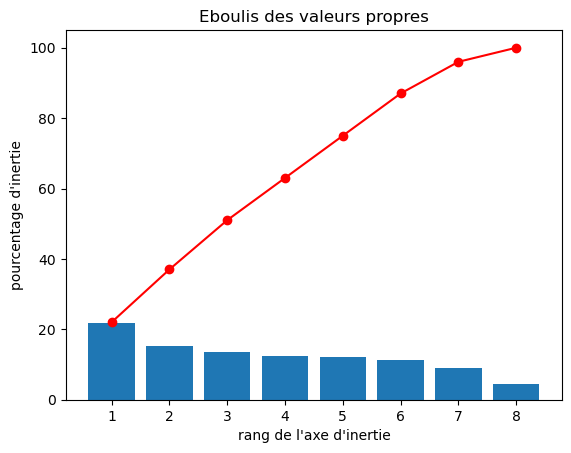

In [93]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

On voit ici que près de 40% de la variance est comprise dans les 2 premières composantes, et plus de 80% dans les 6 premières.

In [94]:
pcs = pca.components_
pcs

array([[-1.60116743e-01,  3.18482829e-01,  6.81618755e-03,
        -1.15334510e-03,  9.99626868e-02, -6.42777088e-01,
        -6.48797942e-01,  1.69675669e-01],
       [ 6.29123659e-01,  6.01339528e-01, -3.23199211e-02,
        -5.22300567e-02,  4.26018040e-01,  2.25619381e-01,
         2.74317388e-03,  8.01163928e-02],
       [ 5.36438506e-02,  1.95896138e-02,  7.05952282e-01,
         7.05125029e-01,  2.21611429e-02,  1.26565641e-02,
        -6.37992118e-04,  2.27363558e-02],
       [-4.09804745e-01, -3.72550510e-02,  1.18870974e-01,
        -9.61945598e-02,  7.74108754e-01, -8.01792761e-02,
         1.74809198e-01, -4.13590493e-01],
       [-2.89028564e-01, -4.96586930e-02, -5.72558998e-03,
        -9.58611802e-03,  2.75713919e-01,  9.86009238e-02,
         2.22473143e-01,  8.82404227e-01],
       [ 6.07615241e-02, -1.28736491e-02,  6.97034975e-01,
        -7.00465062e-01, -1.22550163e-01,  1.29592594e-02,
        -2.87294462e-02,  6.01779124e-02],
       [ 5.33790227e-01, -7.170779

In [95]:
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7
0,-0.160117,0.318483,0.006816,-0.001153,0.099963,-0.642777,-0.648798,0.169676
1,0.629124,0.601340,-0.032320,-0.052230,0.426018,0.225619,0.002743,0.080116
2,0.053644,0.019590,0.705952,0.705125,0.022161,0.012657,-0.000638,0.022736
3,-0.409805,-0.037255,0.118871,-0.096195,0.774109,-0.080179,0.174809,-0.413590
4,-0.289029,-0.049659,-0.005726,-0.009586,0.275714,0.098601,0.222473,0.882404
5,0.060762,-0.012874,0.697035,-0.700465,-0.122550,0.012959,-0.028729,0.060178
6,0.533790,-0.717078,-0.022703,-0.007560,0.323567,-0.228007,-0.180950,0.104255
7,0.188645,0.135482,0.002012,-0.003956,-0.114230,-0.683716,0.682226,0.009472


In [96]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,fat_100g,carbohydrates_100g,sugars_100g,sodium_100g
F1,-0.16,0.32,0.01,-0.00,0.10,-0.64,-0.65,0.17
F2,0.63,0.60,-0.03,-0.05,0.43,0.23,0.00,0.08
F3,0.05,0.02,0.71,0.71,0.02,0.01,-0.00,0.02
F4,-0.41,-0.04,0.12,-0.10,0.77,-0.08,0.17,-0.41
F5,-0.29,-0.05,-0.01,-0.01,0.28,0.10,0.22,0.88
F6,0.06,-0.01,0.70,-0.70,-0.12,0.01,-0.03,0.06
F7,0.53,-0.72,-0.02,-0.01,0.32,-0.23,-0.18,0.10
F8,0.19,0.14,0.00,-0.00,-0.11,-0.68,0.68,0.01


In [97]:
pcs.T

,F1,F2,F3,F4,F5,F6,F7,F8
fiber_100g,-0.160117,0.629124,0.053644,-0.409805,-0.289029,0.060762,0.533790,0.188645
proteins_100g,0.318483,0.601340,0.019590,-0.037255,-0.049659,-0.012874,-0.717078,0.135482
vitamin-a_100g,0.006816,-0.032320,0.705952,0.118871,-0.005726,0.697035,-0.022703,0.002012
vitamin-c_100g,-0.001153,-0.052230,0.705125,-0.096195,-0.009586,-0.700465,-0.007560,-0.003956
fat_100g,0.099963,0.426018,0.022161,0.774109,0.275714,-0.122550,0.323567,-0.114230
carbohydrates_100g,-0.642777,0.225619,0.012657,-0.080179,0.098601,0.012959,-0.228007,-0.683716
sugars_100g,-0.648798,0.002743,-0.000638,0.174809,0.222473,-0.028729,-0.180950,0.682226
sodium_100g,0.169676,0.080116,0.022736,-0.413590,0.882404,0.060178,0.104255,0.009472


<AxesSubplot:>

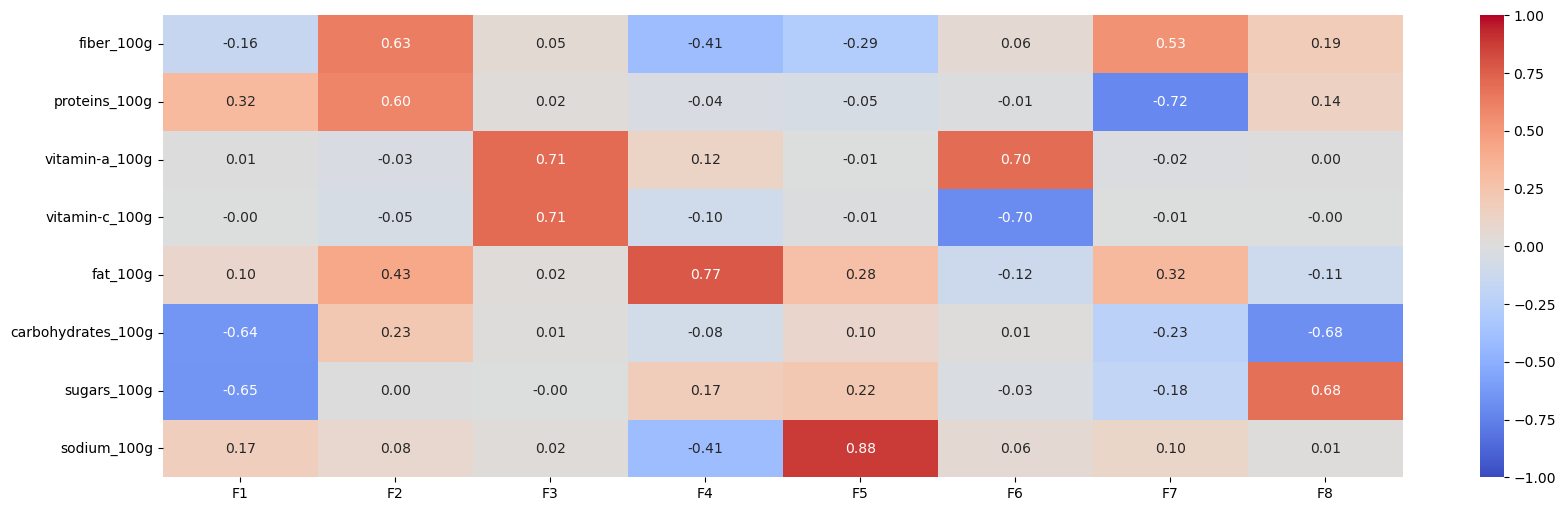

In [98]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Graphe de correlation 

In [99]:
x, y = 0,1

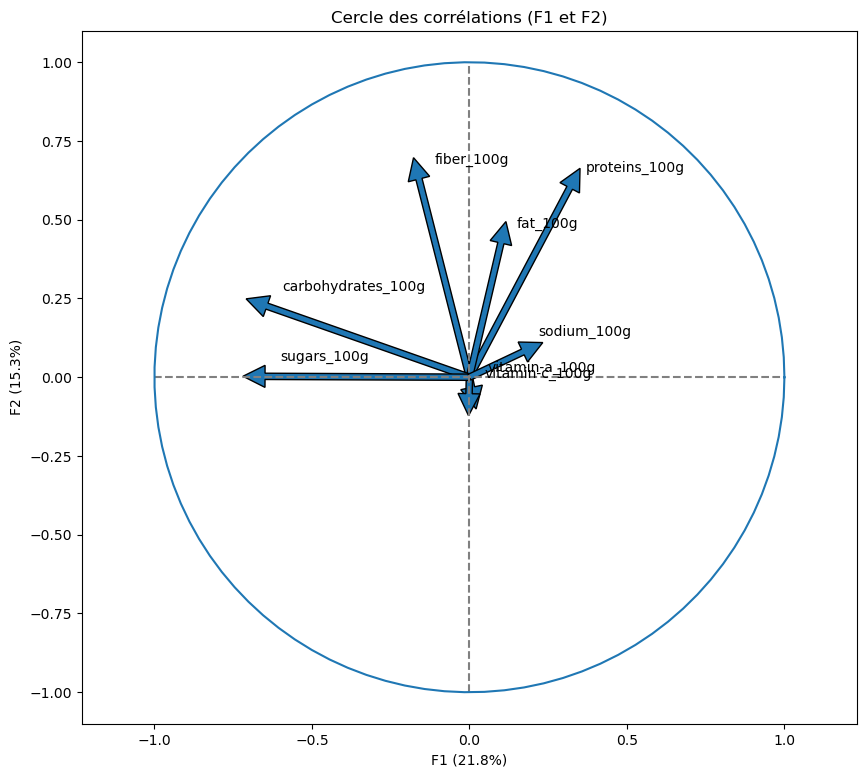

In [100]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

- Créeons la fonction de correlation 

In [101]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
   
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

Pour F1 et F2 il faut bien préciser  0 et 1  

In [102]:
x_y = (0,1)
x_y

(0, 1)

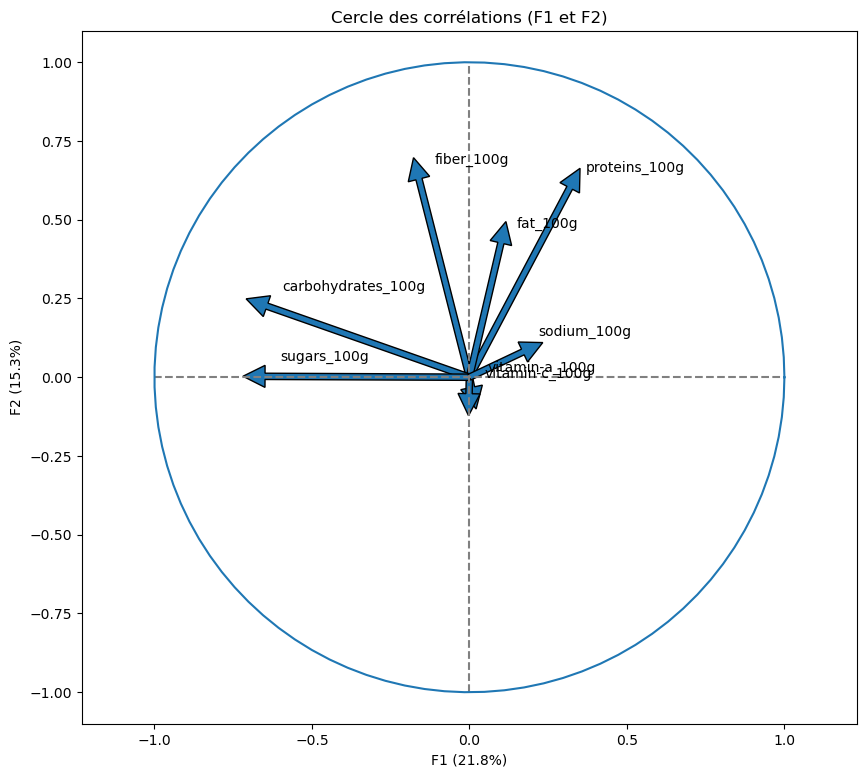

In [103]:
correlation_graph(pca, x_y, features)

Essayons pour F3 et F4 : 

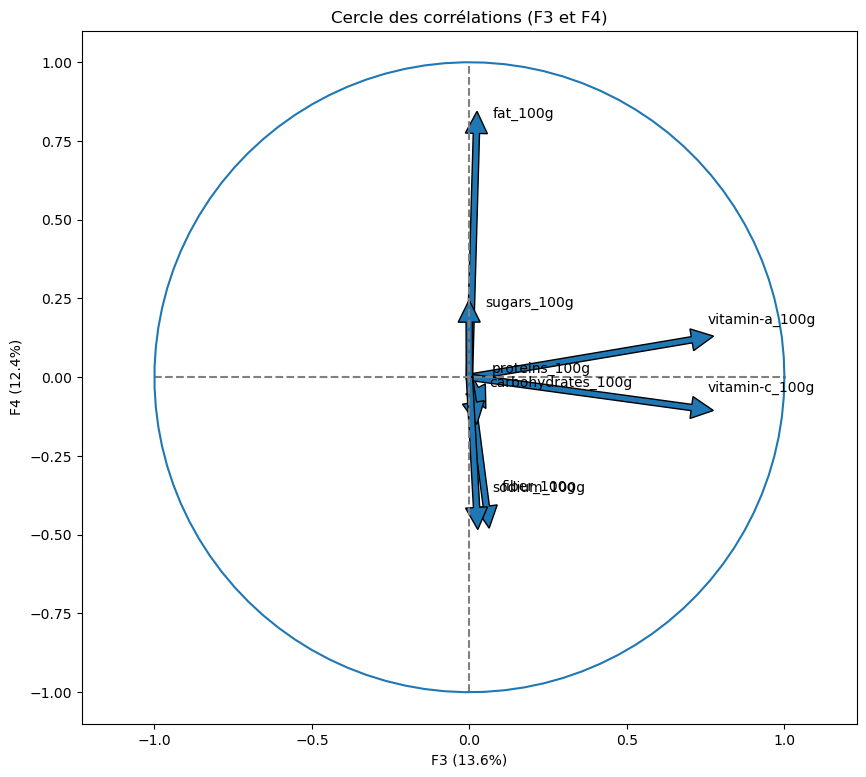

In [104]:
correlation_graph(pca, (2,3), features)

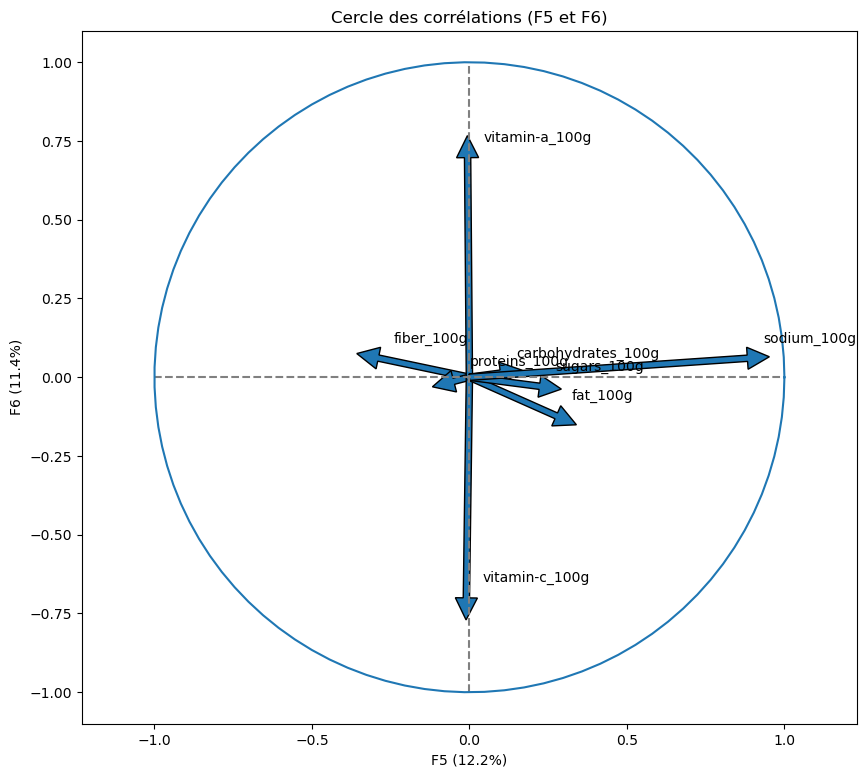

In [105]:
correlation_graph(pca, (4,5), features)

Projection

In [106]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-0.91428168,  0.41987455,  0.01651343, -0.81095948, -0.47720918,
         0.13243577, -0.26665423, -1.52036635],
       [ 0.25211508, -1.17549908, -0.08016848, -0.26347132, -0.32817787,
         0.06083208,  0.13251312,  0.21199527],
       [-0.885471  ,  0.43726906,  0.02466588, -1.06363063, -0.21582408,
         0.16905153, -0.27163904, -1.26850247],
       [ 0.26856995, -0.93490923, -0.06960363, -0.14660767, -0.24583872,
         0.03883622,  0.01906837, -0.01590246],
       [-3.38391311, -0.73618476, -0.05083891, -0.11019624,  0.66497708,
         0.04029083, -0.77540428, -0.06194586]])

In [107]:
x_y

(0, 1)

In [108]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):   

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1  
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)  
    if len(labels) :       
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')  
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

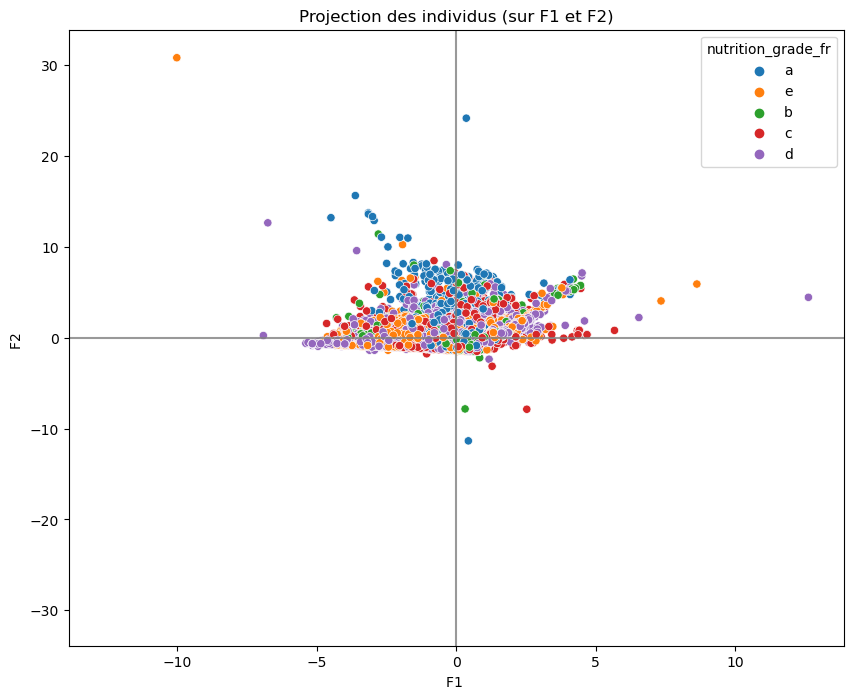

In [109]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=jeu0_C['nutrition_grade_fr'])

La version plus *élaborée* avec F1 et F2 

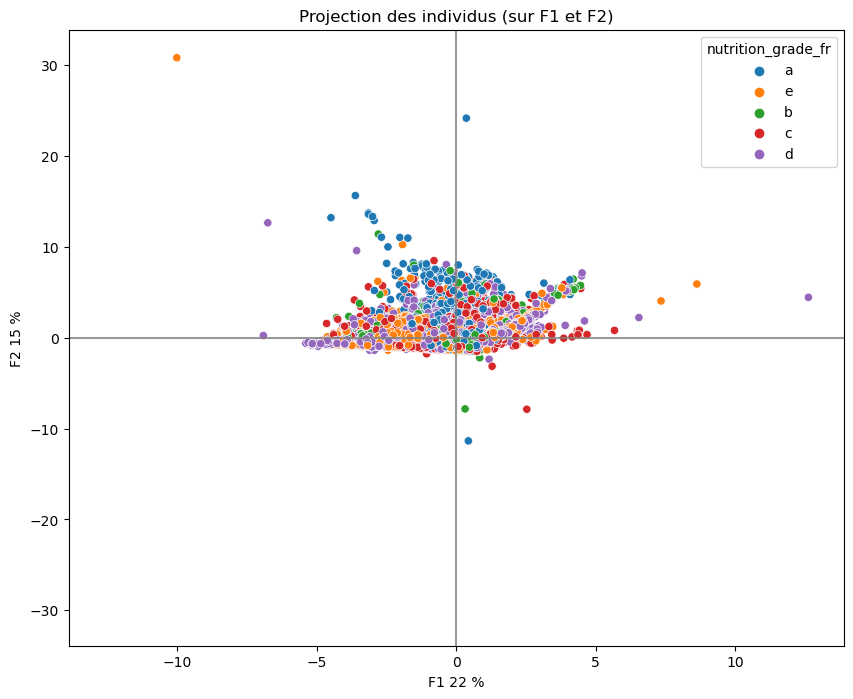

In [110]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'], marker="o")

Essayons avec F2 et F3

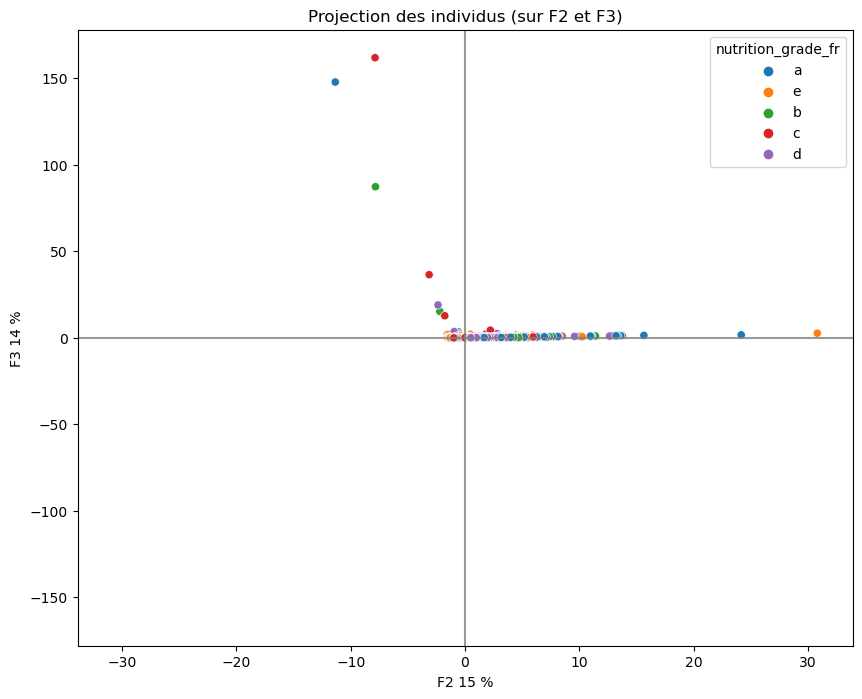

In [111]:
x_y = 1,2
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

Essayons avec F3 et F4

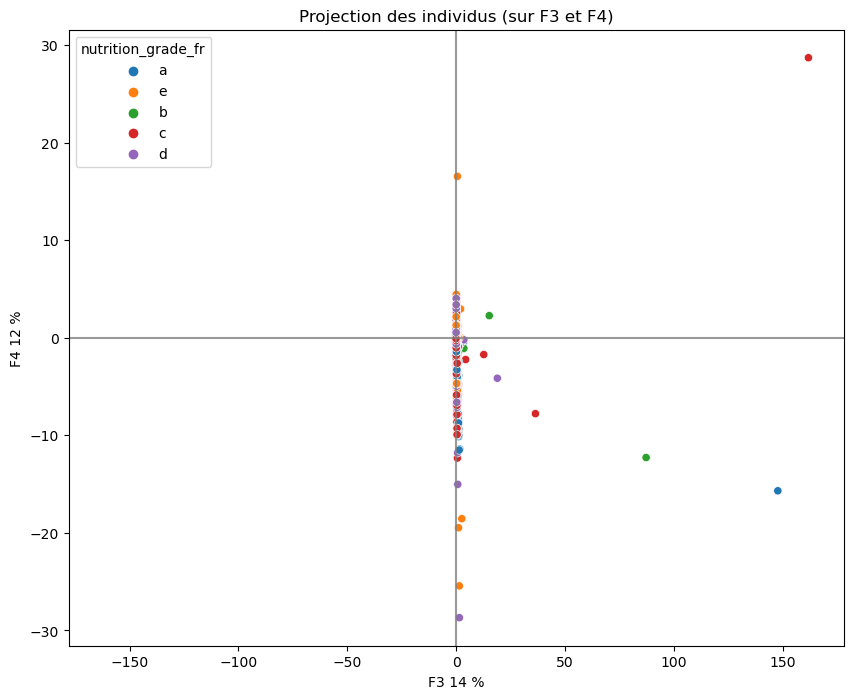

In [112]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

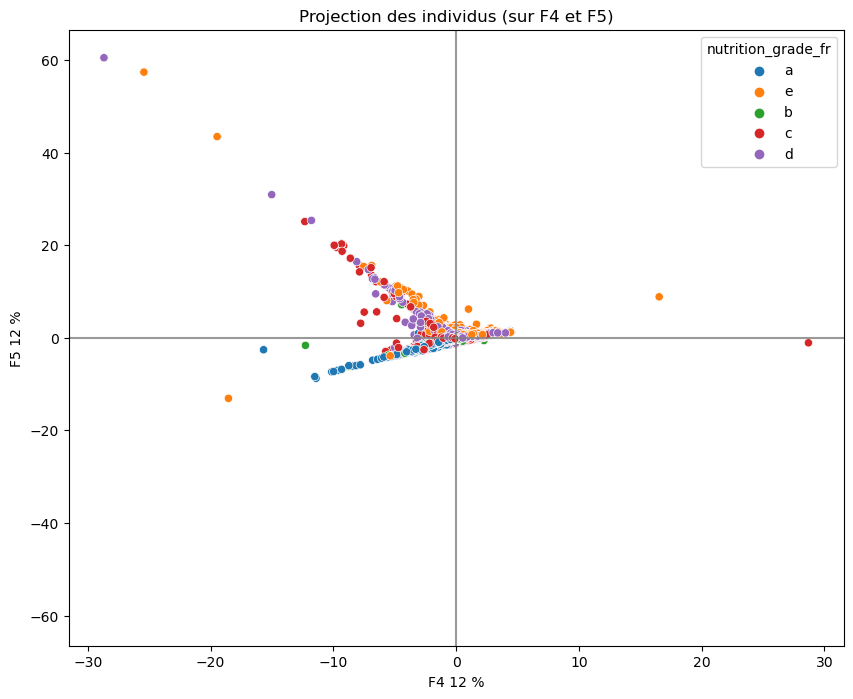

In [113]:
x_y = 3,4
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")

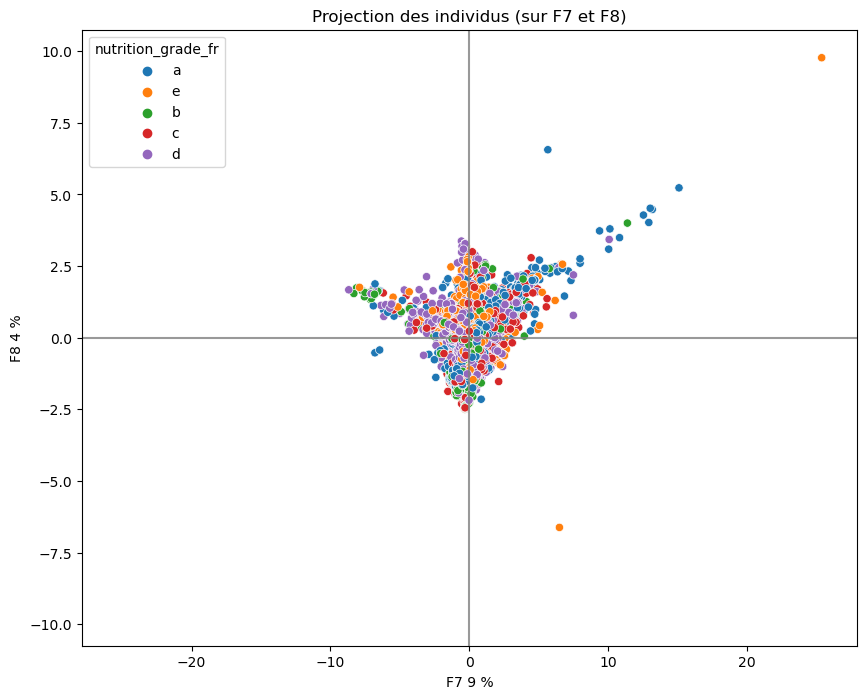

In [114]:
x_y = 6,7
display_factorial_planes(X_proj, x_y, pca,  figsize=(10,8), clusters=jeu0_C['nutrition_grade_fr'],marker="o")